# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 5 ноября 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 5 ноября, -4 балла после 06:00 12 ноября, -6 баллов после 06:00 19 ноября  -8 баллов после 06:00 26 ноября.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 2] Фамилия Имя.<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline
%load_ext pycodestyle_magic
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$$ w_{new} = w_{old} - \alpha \left(\frac{2}{N}\sum_{i=1}^{n}{(x_{i} \cdot w_{old} - y_{i})x_{i}} + \frac{2}{C}w_{old}\right)$$
<b>Интуитивно</b> градиент является направлением наибольшего роста функционала потерь. Мы его вычитаем те, мы движемся в противоположную сторону.

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - \alpha \left(\frac{1}{N}\cdot \sum_{i=1}^{n}\left[\sigma(\langle w_{old},x_i\rangle) - y_i \right] x_i  + \frac{2}{C} w_{old}\right) $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ \nabla_{w}Q(\vec{w}) = -\frac{1}{N} \frac{\partial}{\partial\vec{w}}
\left[\sum_{i=1}^{N}
{y_i \log{\sigma(\langle\vec{w},\vec{x_i}\rangle)} - (1 - y_i) \log{(1-\sigma(\langle\vec{w},\vec{x_i}\rangle))}
}\right] + \frac{1}{C} \frac{\partial}{\partial\vec{w}} \sum_{j=1}^{D}w_j^2
$$


$$ \frac{\partial}{\partial\vec{w}} \left[y_i \log{\sigma(\langle\vec{w},\vec{x_i}\rangle)} + (1 - y_i) \log{(1 - \sigma(\langle\vec{w},\vec{x_i}\rangle))}\right] =\\= \left[\frac{y_i}{\sigma(\langle\vec{w},\vec{x_i}\rangle)} + \frac{1 - y_i}{1 - \sigma(\langle\vec{w}\vec{x_i}\rangle)}\right]\cdot\frac{d\sigma(\langle\vec{w},\vec{x_i}\rangle)}{d\vec{w}} =\\= \\=\left[...\right] \sigma(\langle\vec{w},\vec{x_i}\rangle) \cdot(1 - \sigma(\langle\vec{w},\vec{x_i}\rangle))\vec{x_i} =\\= \left[y_i (1 - \sigma(\langle\vec{w},\vec{x_i}\rangle)) - (1 - y_i) \sigma(\langle\vec{w},\vec{x_i}\rangle)\right] \vec{x_i} =\\= \left[y_i - \sigma(\langle\vec{w},\vec{x_i}\rangle)\right]\vec{x_i} $$

$$
\frac{\partial}{\partial\vec{w}} \sum_{j=1}^{D}w_j^2 = 2 \vec{w}
$$

Таким образом,
$$\nabla_{w}Q(\vec{w}) = -\frac{1}{N}\cdot \sum_{i=1}^{N}\left[y_i - \sigma(\langle\vec{w},\vec{x_i}\rangle)\right] \vec{x_i}  + \frac{2}{C}\vec{w}$$


Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^Ty $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

<div><center><b>Показываю</b></center></div>
$$
\nabla_w Q(w) = 2X^TXw - 2X^Ty\\
\nabla_w Q(w)_i = (2X^TX_i,w)-2X^T_iy\\
\frac{\partial^2Q}{\partial w_i \partial w_j} = (2X^TX)_{ij}\\
$$
<div><center>То есть матрица Гессе $$H(Q(w))$$ в точности равна $$2X^TX$$</center></div>
<div><center>данная матрица положительно определена так как:</center></div>
$$ \forall{A}:\hspace{1cm}(AA^T)^T = (A^T)^TA^T=AA^T $$ 
Матрица $X$ имеет полный ранг $\Longrightarrow Ker(X) = \{0\} \Longrightarrow \forall z \neq 0: z^TXX^Tz = (X^Tz)^T(X^Tz)>0$ , что удовлетворяет критерию положительной определенности матрицы.
<div><center>Гессиан $H(Q(w))$ положительно определен $\Longrightarrow$ рассматриваемая нами критическая точка $w = (X^TX)^{-1}X^Ty $ является точкой минимума.</center></div>
$$$$$$$$
<div><center><b>Точное решение для модели с $L2$ регуляризацией:</b></center></div>
$$
\nabla_w \sum_{i=1}^{D} w_i^2 = 2w\\
\nabla_w Q'(w) = 2X^TXw - 2X^Ty + 2w\\
w = (X^TX+\frac{1}{C}Iw)^{-1}X^Ty 
$$
$L2$ регуляризация устраняет линейную зависимость признаков засчет добавления гребня $\frac{1}{C} I$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$$ -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i)) =\\= -p(y_i = 1 |x_i ) \log a(x_i)  - (1 - p(y_i = 1 | x_i)) \log( 1 - a(x_i)) =\\= p(y_i = 1 |x_i) \log \frac{1 - a(x_i)}{a(x_i)} - \log(1 - a(x_i))$$

<div><center>Для удобства запишем последнее в виде:</center></div>
$$ p \cdot \log\frac{1-a}{a} - \log(1-a)$$
<div><center>Дифференцируя по a получим</center></div>
$$ \frac{a-p}{(1-a)a}$$
<div><center>Приравняв к нулю получаем, что a=p точка минимума исходной функции, т.к. производная меняет свой знак с отрицательного на положительный, проходя через эту точку</center></div>


Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$



***Ваше решение здесь***

$f_0 = 1$ вводится для удобства. $w_0$ вводится для линейности модели. $w_0$ отвечает за псевдопризнак $f_0$ равный $1$ для всех объектов класса. Цель регуляризации - настройка весов значащих признаков нашей модели во избежание переобучения. Но признак $f_0$ не зависит от остальных. $\Longrightarrow$ Ответ нет.

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    storage = np.concatenate((X, y[:, None]), axis=1)
    if shuffle:
        np.random.shuffle(storage)
    for i in np.vsplit(storage[:(storage.shape[0]//batch_size*batch_size)], storage.shape[0]//batch_size):
        yield (i[:, :-1], i[:, -1].flatten())



In [7]:
#%%pycodestyle


def sigmoid(x):
    return 1/(1 + np.exp(-x))


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10, model_type='lin_reg'):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):
        a = np.dot(X_batch, self.weights)
        if self.model_type == 'lin_reg':
            buf = (y_batch - a)
            loss = 1/X_batch.shape[0] * np.dot(buf,buf)
        elif self.model_type == 'log_reg':
            a = sigmoid(a)
            buf = y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)
            loss = -1 / X_batch.shape[0] * np.sum(buf)
        return loss + 1 / self.C * np.dot(self.weights, self.weights)

    def calc_loss_grad(self, X_batch, y_batch):
        if self.model_type == 'lin_reg':
            buf = (np.dot(X_batch, self.weights) - y_batch)[:, None]
            buf = buf * X_batch
            loss_grad = 2 / X_batch.shape[0] * np.sum(buf, axis = 0)
        elif self.model_type == 'log_reg':
            buf = (sigmoid(np.dot(X_batch, self.weights)) - y_batch)[:, None]
            buf = buf * X_batch
            loss_grad = 1 / X_batch.shape[0] * \
                    np.sum(buf, axis = 0)
        r = 2 / self.C * self.weights
        r[0] = 0
        return loss_grad + r 

    def update_weights(self, new_grad):
        self.weights = self.weights - self.alpha * new_grad
        pass
    
    def fit(self, X, y):
        self.weights = np.random.rand(X.shape[1] + 1)
        for n in tqdm(range(0, self.max_epoch)):
            buf = np.hstack((np.ones((X.shape[0], 1)), X))
            new_epoch_generator = self.batch_generator(buf, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]

                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                self.update_weights(batch_grad)              
        return self

    def predict(self, X):
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights[1::])
            return (y_hat > 0).astype(int)
        elif self.model_type == 'log_reg':
            buf = np.hstack((np.ones((X.shape[0], 1)), X))
            y_hat = np.dot(buf, self.weights)
            return (sigmoid(y_hat) > 0.5).astype(int)


Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf):
    x = np.linspace(-4, 8, 100)
    y = -clf.weights[1] / clf.weights[2] * x - \
        clf.weights[0] / clf.weights[2]
    plt.plot(x, y)
    pass


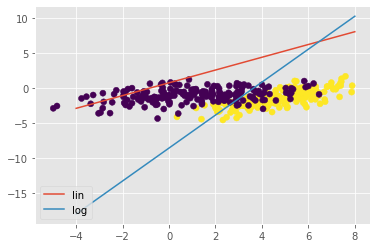

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
your_model = MySGDClassifier(batch_generator,
                             max_epoch=10,
                             model_type='lin_reg',
                             alpha=0.01, C=1)
your_model.fit(X, y)
plot_decision_boundary(your_model)
your_model = MySGDClassifier(batch_generator,
                             max_epoch=10,
                             model_type='log_reg',
                             alpha=0.01,
                             C=1)
your_model.fit(X, y)
plot_decision_boundary(your_model)
plt.legend(['lin', 'log'], loc='lower left')

plt.scatter(X[:, 0], X[:, 1], c=y)


Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 


100000
(100, 1000)



100000
(100, 1000)



100000
(100, 1000)


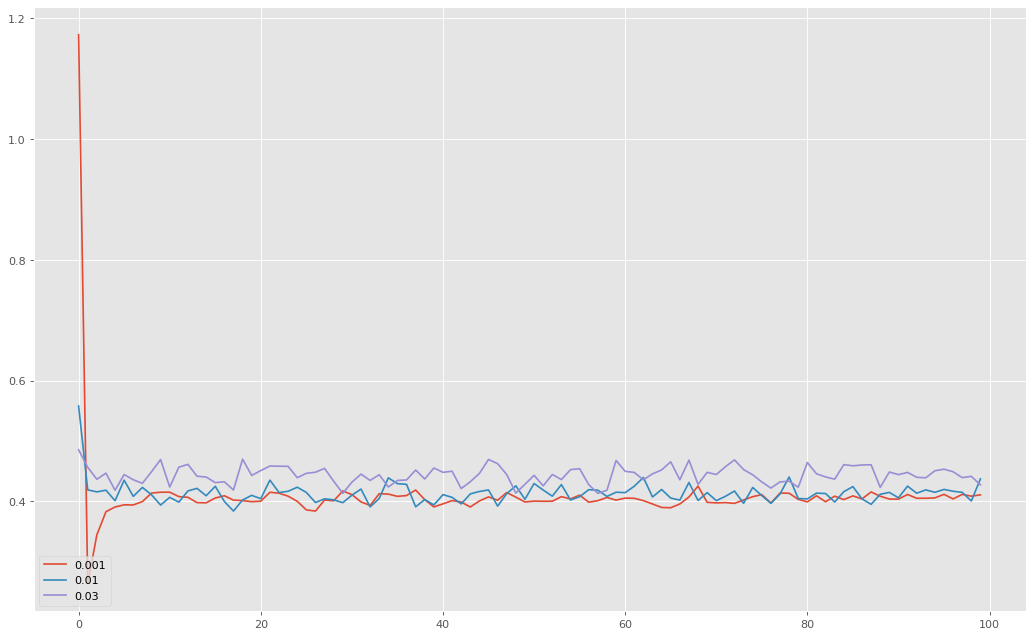

In [12]:
colors = ['r', 'g', 'b']

plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
N = 1000
for a in [0.001, 0.01, 0.03]:
    myclf = MySGDClassifier(batch_generator, max_epoch=1, alpha=a)
    myclf.fit(X, y)
    print(len(myclf.errors_log['loss']))
    buf = np.reshape(myclf.errors_log['loss'], (-1, N))
    print(buf.shape)
    buf = np.mean(buf, axis=1).flatten()

    plt.plot(range(X.shape[0] // N), buf)
plt.legend(['0.001', '0.01', '0.03'], loc='lower left')


Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

[1.00000000e+03 2.15443469e+02 4.64158883e+01 1.00000000e+01
 2.15443469e+00 4.64158883e-01 1.00000000e-01 2.15443469e-02
 4.64158883e-03 1.00000000e-03]



[0.03431215621692604, 0.03443303976902431, 0.03480180849742759, 0.03557259964433934, 0.037935785517214486, 0.04002167461611233, 0.04272574118357069, 0.04443999249803207, 0.0452598028057229, 0.045550170220832624]


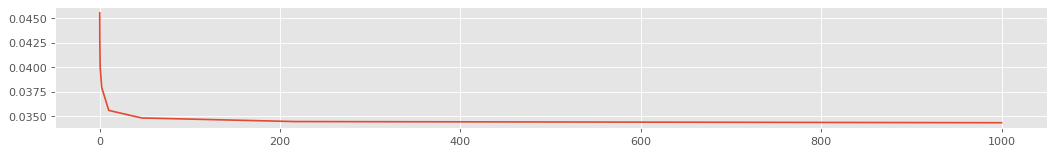

In [13]:
colors = ['r', 'g', 'b']


plt.figure(num=None, figsize=(16, 2), dpi=80, facecolor='w', edgecolor='k')
print(np.logspace(3, -3, 10))
w = []
for i in np.logspace(3, -3, 10):
    myclf = MySGDClassifier(batch_generator,
                            C=i,
                            alpha=0.00001,
                            max_epoch=10,
                            model_type='lin_reg')
    myclf.fit(X.astype('float64'), y.astype('float64'))
    w.append(np.mean(myclf.weights))
print(w)
plt.plot(np.logspace(3, -3, 10), w)


Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [14]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [15]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [16]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [17]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)
cur = []
scaler = StandardScaler()

myclf = MySGDClassifier(batch_generator,
                        C=1, alpha=0.001,
                        max_epoch=100,
                        model_type='lin_reg')
for i, j in skf.split(X_train, y_train):
    myclf.fit(scaler.fit_transform(X_train[i]), y_train[i])
    cur.append(f1_score(myclf.predict(scaler.fit_transform(X_train[j])),
                        y_train[j]))
res = np.mean(cur)
print(res)



0.6167290012254651


In [18]:
print('hello')

hello


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [19]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print(X_test.shape, groups_test.shape)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
myclf = MySGDClassifier(batch_generator,
                        C=1,
                        alpha=0.001,
                        max_epoch=100,
                        model_type='lin_reg')
myclf.fit(X_train, y_train)
y_test_pred = myclf.predict(X_test_scaled)
print(len(y_test_pred))

ans_data = {'pair_id': [], 'target': []}
ans_data['pair_id'] = test_data['pair_id']
ans_data['target'] = np.array(y_test_pred, dtype=int)
df = pd.DataFrame(ans_data, columns=['pair_id', 'target'])
df.to_csv('my_prediction.csv', index=None)


(16627, 15) (16627,)



16627


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [21]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)
cur = []
scaler = StandardScaler()

myclf = MySGDClassifier(batch_generator,
                        C=1,
                        alpha=0.01,
                        max_epoch=10,
                        model_type='log_reg')
for i, j in skf.split(X_train, y_train):
    myclf.fit(scaler.fit_transform(X_train[i]), y_train[i])
    cur.append(f1_score(myclf.predict(scaler.fit_transform(X_train[j])),
                        y_train[j]))
res = np.mean(cur)
print(res)



0.3428118379651714


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук прислать Ваш ник на kaggle, под которым Вы залили решение, которое побило первый бейзлайн. **

<b>soapun</b>

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***



* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

In [ ]:
Мне понравилось сидеть и лампово техать. Такая своеобразная медитация.